<a href="https://colab.research.google.com/github/CleberJesus/machine_learning/blob/main/machine_learning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementando uma Deep Learning do zero em python**

In [12]:
import numpy as np
import torch
import torch.nn.functional as f
import torchvision
import matplotlib.pyplot as plt
from  time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [13]:
transform = transforms.ToTensor()

#carrega a parte de treino do dataset
trainset = datasets.MNIST('./MNIST_data/', download=True, transform=transform)
#cria um buffer para pegar os dados por partes
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

#carrega a parte de validação
valset = datasets.MNIST('./MNIST_data/', download=True, transform=transform)
#cria um buffer para pegar os dados por
valloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

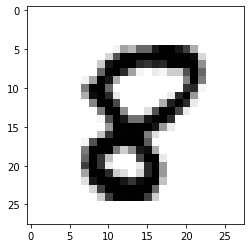

In [14]:
dataiter = iter(trainloader)
imagens, etiquetas = dataiter.next()
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r')

In [15]:
#verificar as dimensões do tensor de cada imagem
print(imagens[0].shape)
#verificar as dimensões do tensor de cada etiqueta
print(etiquetas[0].shape)

torch.Size([1, 28, 28])
torch.Size([])


In [16]:
from torch.nn.modules.upsampling import F
class Modelo(nn.Module):
  def __init__(self):
    super(Modelo, self).__init__()
    #camada de entrada, 784 neurônios que se ligam a 128
    self.linear1 = nn.Linear(28*28, 128)
    #camada interna 1, 128 neurônios que se ligam a 64
    self.linear2 = nn.Linear(128, 64)
    #camada interna 2, 64 neurônios que se ligam a 10
    self.linear3 = nn.Linear(64, 10)
    #para cada camada de saída não é necessário definir nada pois só precisamos pegar o output da camada interna 2


  def forward(self, x):
    #função de ativação da camada de entrada para a camada interna 1
    x = F.relu(self.linear1(x))
    #função de ativação da camada de entrada para a camada interna 2
    x = F.relu(self.linear2(x))
    #função de ativação da camada de entrada para a camada interna 2 para a camada de saida, nesse caso f(x) = x
    return F.log_softmax(x, dim=1)#dados utilizados para calcular a perda

In [17]:
from prompt_toolkit import output
def treino(modelo, trainloader, device):
  #define a politica de atualização dos pesos e da baias
  otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5)
  #timer para sabermos quanto tempo levou o treino
  inicio = time()

  #definindo o critério para calcular a perda
  criterio = nn.NLLLoss()
  EPOCHS = 30 #numero de epochs que o algorismo rodará
  modelo.train()#ativando o modo de treinamento do modelo

  for epoch in range(EPOCHS):
    perda_acumulada = 0 #inicialização da perda acumulada da epoch em questão
    for imagens, etiquetas in trainloader:
      #convertendo as imagens para vetores de 28*28 casas para ficarem compatíveis
      imagens = imagens.view(imagens.shape[0], -1)
      otimizador.zero_grad()#zerando os gradientes por conta do ciclo anterior

      output = modelo(imagens.to(device)) # colocando os dados no modelo
      perda_instantanea = criterio(output, etiquetas.to(device)) # calculando a perda da epoch em questão

      perda_instantanea.backward()#back propagation a partir da perda

      otimizador.step()#atualizando os pesos e a baias

      perda_acumulada += perda_instantanea.item()#atualização da perda acumulada

    
    else:
      print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
  print("\nTempo de Treino (em minuto) = ",(time()-inicio)/60)

In [18]:
def validacao(modelo, valloader, device):
  conta_corretas, conta_todas = 0,0
  for imagens, etiquetas in valloader:
    for i in range(len(etiquetas)):
      img = imagens[1].view(1, 784)
      #desativar o autograd para acelerar a validação, grafos computacionais dinâmicos tem um custo alto de processamento
      with torch.no_grad():
        logps = modelo(img.to(device))


      ps = torch.exp(logps) #converte outpu para escala normal(lembrando que é um tensor)
      probab = list(ps.cpu().numpy()[0])
      #converte o tensor em numero, no caso que o modelo previu como correto
      etiqueta_pred = probab.index(max(probab))
      etiqueta_certa = etiquetas.numpy()[i]
      if(etiqueta_certa == etiqueta_pred):# compara a previsão com o valor correto
        conta_corretas += 1
      conta_todas += 1

  print("total de imagens testadas = ", conta_todas)
  print("\nPrecisão do modelo = {}".format(conta_corretas*100/conta_todas))


In [19]:
modelo = Modelo()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)